## Импорт библиотек, данных

In [43]:
import warnings

import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.compose import make_column_transformer

from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_score,
    recall_score
)

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegressionCV

from catboost import CatBoostClassifier

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

warnings.filterwarnings("ignore")

RANDOM_STATE = 30423

In [6]:
df_contract = pd.read_csv('/datasets/contract_new.csv')
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_phone = pd.read_csv('/datasets/phone_new.csv')

## Исследовательский анализ данных

Начнем анализ с первого взгляда на данные в таблицах, кроме этого, оценим общую информацию о датасетах.

In [7]:
print('Информация о договоре')
display(df_contract.head())
df_contract.info()
print('*'*100)

print('Информация об интернет-услугах')
display(df_internet.head())
df_internet.info()
print('*'*100)

print('Информация о клиенте')
display(df_personal.head())
df_personal.info()
print('*'*100)

print('Информация об услугах телефонии:')
display(df_phone.head())
df_phone.info()

Информация о договоре


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
****************************************************************************************************
Информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
****************************************************************************************************
Информация о клиенте


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
****************************************************************************************************
Информация об услугах телефонии:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Сразу можно выделить несколько вещей:
* Названия столбцов не стандартизированы.
* Строчек в `df_internet` и `df_phone` меньше, чем в `df_contract` и `df_personal`.
* Данных сравнительно немного (7043 объектов).
* Явных пропусков в столбцах нет.
* Некоторые столбцы имеют неподходящие типы данных.

Для удобства сразу приведем названия столбцов к snake_case. Для этого воспользуемся регулярными выражениями и библиотекой `re`.

In [8]:
df_contract = df_contract.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x).lower())
df_internet = df_internet.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x).lower())
df_personal = df_personal.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x).lower())
df_phone = df_phone.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x).lower())

Оценим информацию в каждой таблице отдельно.

In [9]:
def data_info(df):
    print('Полных дублей в таблице:', df.duplicated().sum())
    for col in df.columns:
        print(f'Уникальные значения в поле {col}:')
        print(df[col].unique())

### df_contract

In [10]:
data_info(df_contract)

Полных дублей в таблице: 0
Уникальные значения в поле customer_id:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения в поле begin_date:
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '20

### df_internet

In [11]:
data_info(df_internet)

Полных дублей в таблице: 0
Уникальные значения в поле customer_id:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения в поле internet_service:
['DSL' 'Fiber optic']
Уникальные значения в поле online_security:
['No' 'Yes']
Уникальные значения в поле online_backup:
['Yes' 'No']
Уникальные значения в поле device_protection:
['No' 'Yes']
Уникальные значения в поле tech_support:
['No' 'Yes']
Уникальные значения в поле streaming_tv:
['No' 'Yes']
Уникальные значения в поле streaming_movies:
['No' 'Yes']


### df_personal

In [12]:
data_info(df_personal)

Полных дублей в таблице: 0
Уникальные значения в поле customer_id:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения в поле gender:
['Female' 'Male']
Уникальные значения в поле senior_citizen:
[0 1]
Уникальные значения в поле partner:
['Yes' 'No']
Уникальные значения в поле dependents:
['No' 'Yes']


### df_phone

In [13]:
data_info(df_phone)

Полных дублей в таблице: 0
Уникальные значения в поле customer_id:
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения в поле multiple_lines:
['No' 'Yes']


Анализ данных позволяет сделать следующие выводы:
* В данных отсутствуют дубликаты объектов.
* Присутствуют пропуски, связанные со слиянием датасетов.
* В категориальных фичах отсутствуют нелогичные значения
* Перед применением алгоритмов ML требуется обработать данные (заполнение пропусков, приведение к соответствующим типам данных).

Для дальнейшего анализа будет удобнее объединить датафреймы в один, чтобы можно было охватить все данные сразу. Объединим таблицы по `customer_id`.

In [14]:
df_all = df_contract.merge(df_internet, how='left', on='customer_id')
df_all = df_all.merge(df_personal, how='left', on='customer_id')
df_all = df_all.merge(df_phone, how='left', on='customer_id')

# сохраним изначальное количество записей, чтобы посчитать потери после обработки данных
rows_cnt_before = df_all.shape[0]

При последующем переводе поля `total charges` к типу `datetime` обнаружились некорректные пустые строковые значения. Рассмотрим их. Видим, что эти клиенты заключили договор в феврале 2020 года, когда как раз и были выгружены данные, поэтому общая сумма оплаты отсутствует.

In [15]:
df_all[df_all['total_charges']==' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


Так как у нас всего 11 подобных объектов, мы можем их удалить без ущерба для общего датасета.

In [16]:
df_all = df_all[df_all['total_charges'] != ' ']

Изменим типы данных в столбцах на более подходящие. 

In [17]:
df_all['begin_date'] = pd.to_datetime(df_all['begin_date'], format='%Y-%m-%d')
df_all['total_charges'] = df_all['total_charges'].astype('float64')

#Если клиент еще не ушел, это отображается как 'No'. Заменим это значение на дату, когда извлекали данные.
df_all['end_date'] = df_all['end_date'].replace({'No':'2020-02-01'})
df_all['end_date'] = pd.to_datetime(df_all['end_date'], format='%Y-%m-%d')

Столбец, содержащий данные о целевом признаке, - `end_date`, так как мы хотим предсказать уйдет клиент в ближайшее время или нет. Для того, чтобы отделить активных от ушедших, добавим новое поле `is_active`, содержащий булевый тип.

In [18]:
df_all['is_active'] = df_all.apply(lambda x: 1 if x['end_date'] == pd.to_datetime('2020-02-01') else 0, axis=1)

Добавим новое поле, отображающее сколько дней пользователь является или являлся абонентом. 

In [19]:
#Cоздаем столбец простым вычитанием.
df_all['days_active'] = (df_all['end_date'] - df_all['begin_date']).dt.days

Также разделим пользователей на использующих интернет-услуги и использующих услуги телефонии. Логично предположить, что отсутствие данных о клиенте в соответствующих таблицах говорит нам о том, что клиент не пользуется данными услугами. Добавим столбцы `phone_user` и `internet_user`, отражающие эту информацию.

In [20]:
df_all['internet_user'] = df_all.apply(lambda x: 0 if x['internet_service'] != x['internet_service'] else 1, axis=1)
df_all['phone_user'] = df_all.apply(lambda x: 0 if x['multiple_lines'] != x['multiple_lines'] else 1, axis=1)

Теперь можем заполнить пропуски значениями `False`. Для пропусков в `internet_service` выделим отдельную категорию `not_user`.

In [21]:
df_all['internet_service'] = df_all['internet_service'].fillna('not_user')
df_all = df_all.fillna('No')

Снова проверим подчищенные и дополненные данные.

In [22]:
data_info(df_all)

Полных дублей в таблице: 0
Уникальные значения в поле customer_id:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения в поле begin_date:
<DatetimeArray>
['2020-01-01 00:00:00', '2017-04-01 00:00:00', '2019-10-01 00:00:00',
 '2016-05-01 00:00:00', '2019-09-01 00:00:00', '2019-03-01 00:00:00',
 '2018-04-01 00:00:00', '2019-04-01 00:00:00', '2017-07-01 00:00:00',
 '2014-12-01 00:00:00', '2019-01-01 00:00:00', '2018-10-01 00:00:00',
 '2015-04-01 00:00:00', '2015-09-01 00:00:00', '2018-01-01 00:00:00',
 '2014-05-01 00:00:00', '2015-10-01 00:00:00', '2014-03-01 00:00:00',
 '2018-05-01 00:00:00', '2019-11-01 00:00:00', '2019-02-01 00:00:00',
 '2016-01-01 00:00:00', '2017-08-01 00:00:00', '2015-12-01 00:00:00',
 '2014-02-01 00:00:00', '2018-06-01 00:00:00', '2019-12-01 00:00:00',
 '2017-11-01 00:00:00', '2019-06-01 00:00:00', '2016-04-01 00:00:00',
 '2017-02-01 00:00:00', '2018-12-01 00:00:00', '2014-04-01 00:00:00',
 '2018-09-01 00:00:00',

Построим боксплоты для `monthly_charges` и `total_charges` для исследования на предмет выбросов.

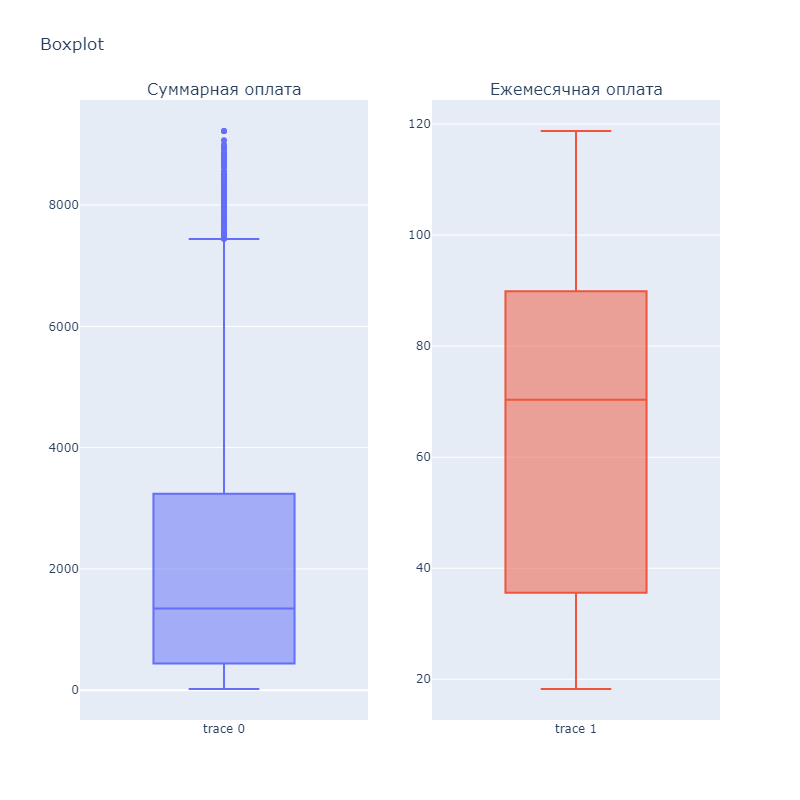

In [23]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Суммарная оплата', 'Ежемесячная оплата'])

fig.add_trace(go.Box(y=df_all['total_charges']), row=1, col=1)
fig.add_trace(go.Box(y=df_all['monthly_charges']), row=1, col=2)

fig.update_layout(height=800, width=800, title_text="Boxplot", showlegend=False)
fig.show('png')

Выбросы на графике для ежемесячной оплаты отсутствуют. На графике суммарной оплаты присутствует некоторое количество выбросов. Для их удаления воспользуемся 99-ым перцентилем.

In [24]:
quant = df_all['total_charges'].quantile(0.99)

df_all = df_all.query('total_charges < @quant')

Продолжим изучать количественные признаки.
Построим гистограммы по `monthly_charges` отдельно для активных и неактивных пользователей, а также суммарный график.

На гистограммах видно, что пик ежемесячной оплаты выше у неактивных пользователей, он находится в районе 100, у активных пользователей преобладающее значение находится в районе 18-22. Однако, более "жирные" ушедшие пользователи не оказывают большого влияния на итоговый график, т.к. их в несколько раз меньше, чем активных.

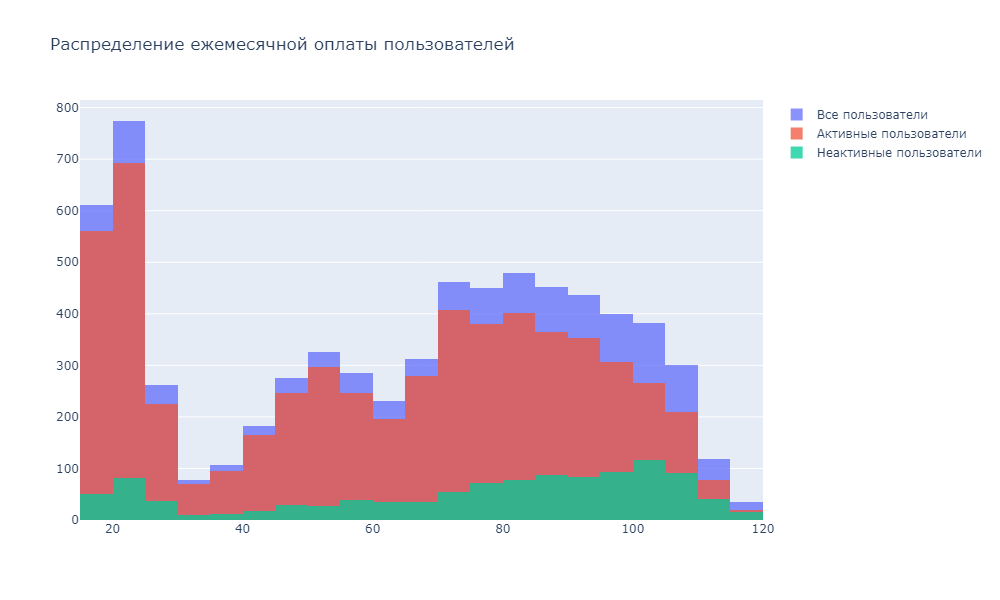

In [25]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(x=df_all['monthly_charges'], name='Все пользователи', nbinsx=50)
)

fig.add_trace(
    go.Histogram(x=df_all.query('is_active == True')['monthly_charges'], name='Активные пользователи', nbinsx=50)
)

fig.add_trace(
    go.Histogram(x=df_all.query('is_active == False')['monthly_charges'], name='Неактивные пользователи', nbinsx=50)
)

fig.update_layout(height=600, width=1000,
                  title_text="Распределение ежемесячной оплаты пользователей",
                  barmode='overlay',
                  showlegend=True
                 )

fig.update_traces(opacity=0.75)

fig.show('png')

Гистограммы по суммарной оплате показывают, что большая часть активных пользователей в сумме заплатила до 500 долларов, график для неактивных пользователей распределен равномернее в промежутке от 500 до 3000 долларов.

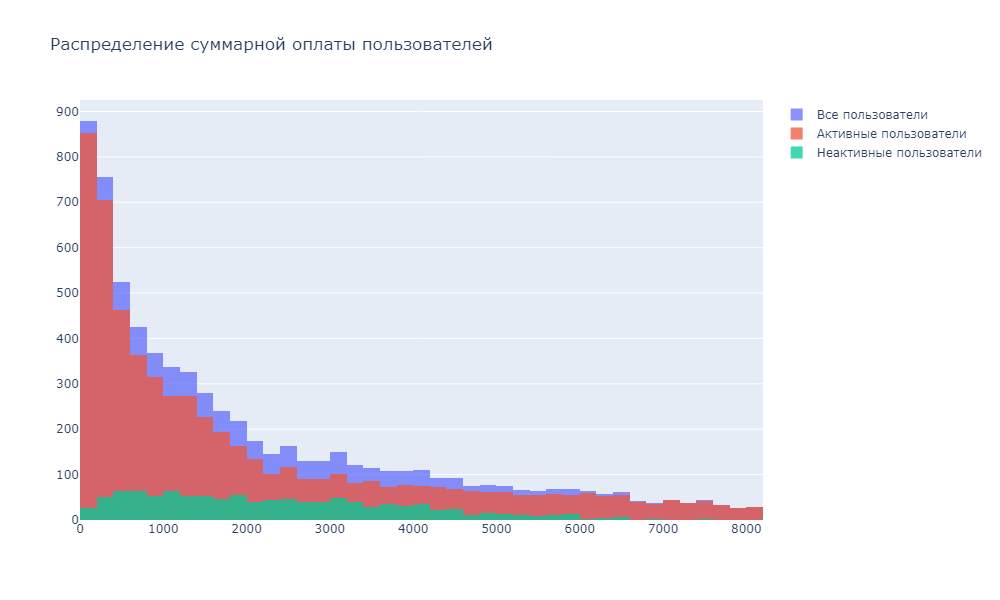

In [26]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(x=df_all['total_charges'], name='Все пользователи')
)

fig.add_trace(
    go.Histogram(x=df_all.query('is_active == True')['total_charges'], name='Активные пользователи')
)

fig.add_trace(
    go.Histogram(x=df_all.query('is_active == False')['total_charges'], name='Неактивные пользователи')
)

fig.update_layout(height=600, width=1000,
                  title_text="Распределение суммарной оплаты пользователей",
                  barmode='overlay',
                  showlegend=True
                 )

fig.update_traces(opacity=0.75)

fig.show('png')

Рассмотрим также статистические показатели для наших данных. Изучим также данные в разбивке по активности и суммарно.

Данные подтверждают гистограммы, описанные выше. Медианное значение у ушедших пользователей на 15 единиц для ежемесячной и на 1000 единиц для суммарной оплаты больше, чем у оставшихся, по этим показателям видно, что ушедшие пользователи в среднем платили больше. Стандартное отклонение в сравнении показывает, что средний разброс значений для ежемесячной оплаты примерно одинаков для обоих групп, когда как для суммарной оплаты разброс выше для активных пользователей.

In [27]:
print('Значения для активных пользователей')
display(df_all.query('is_active == True')[['total_charges', 'monthly_charges']].describe())
print('*'*100)
print('Значения для ушедших пользователей')
display(df_all.query('is_active == False')[['total_charges', 'monthly_charges']].describe())
print('*'*100)
print('Значения для всех пользователей')
display(df_all[['total_charges', 'monthly_charges']].describe())

Значения для активных пользователей


,total_charges,monthly_charges
count,5860.000000,5860.000000
mean,1994.035597,62.183831
std,2089.891954,29.482424
min,19.050000,18.250000
25%,372.677500,29.750000
50%,1170.125000,68.975000
75%,3056.577500,86.250000
max,8158.220000,118.600000


****************************************************************************************************
Значения для ушедших пользователей


,total_charges,monthly_charges
count,1101.000000,1101.000000
mean,2371.377275,75.546004
std,1581.862275,29.116213
min,77.840000,18.400000
25%,1048.050000,56.150000
50%,2139.030000,84.200000
75%,3404.910000,99.500000
max,7649.760000,118.750000


****************************************************************************************************
Значения для всех пользователей


,total_charges,monthly_charges
count,6961.000000,6961.000000
mean,2053.718572,64.297285
std,2022.664016,29.824050
min,19.050000,18.250000
25%,433.000000,35.200000
50%,1323.600000,70.150000
75%,3174.900000,89.550000
max,8158.220000,118.750000


Проверим популярность различных услуг для пользователей интернет- и телефонных услуг.

In [28]:
int_perc = round(df_all[df_all['internet_user'] == True].shape[0] * 100 / df_all.shape[0], 2)
phone_perc = round(df_all[df_all['phone_user'] == True].shape[0] * 100 / df_all.shape[0], 2)

print(f'{int_perc}% пользователей подключили интернет')
print(f'{phone_perc}% пользователей подключили телефон')

internet_services= ['online_security', 'online_backup', 'device_protection',
                    'tech_support', 'streaming_tv', 'streaming_movies']

def users(type, service):
    perc = round(df_all[(df_all[type] == True) & (df_all[service] == 'Yes')].shape[0] / df_all[df_all[type] == True].shape[0] * 100, 2)
    print(f'{perc}% пользуются {service}')

for service in internet_services:
    users('internet_user', service)
users('phone_user', 'multiple_lines')

78.16% пользователей подключили интернет
90.23% пользователей подключили телефон
35.89% пользуются online_security
43.36% пользуются online_backup
43.14% пользуются device_protection
36.26% пользуются tech_support
48.37% пользуются streaming_tv
48.89% пользуются streaming_movies
46.11% пользуются multiple_lines


По данным об услугах можно сделать следующие выводы:

* Телефоном пользуются больше абонентов, чем интернетом (90%/78%)
* Наименее популярная из дополнительных услуг - блокировка небезопасных сайтов. Ее подключает 36% пользователей, из тех, кто пользуется интернетом.
* Наиболее популярная из дополнительных услуг - онлайн-кинотеатр. Услугу подключает 49% пользователей, из тех, кто пользуется интернетом.


Посмотрим на соотношение активных и неактивных пользователей.

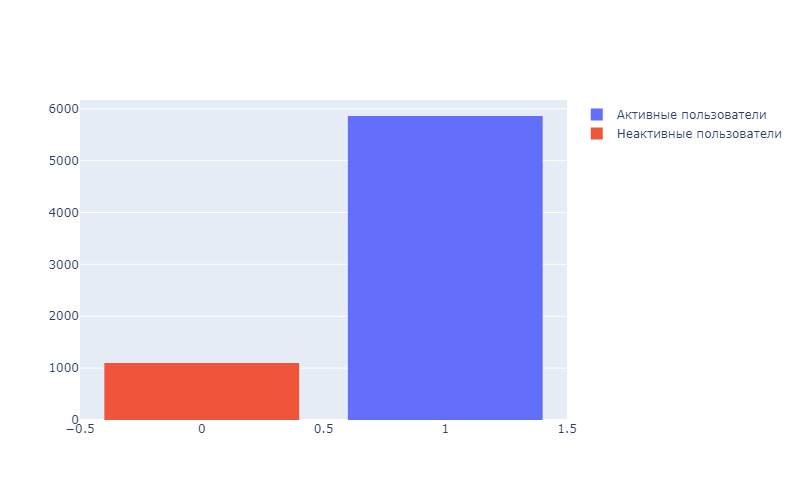

In [29]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(x=df_all.query('is_active == True')['is_active'], name='Активные пользователи')
)

fig.add_trace(
    go.Histogram(x=df_all.query('is_active == False')['is_active'], name='Неактивные пользователи')
)

fig.update_layout(width=800, height=500)

fig.show('png')

По графику видно, что признак несбалансирован - активных пользователей примерно в 6 раз больше неактивных.

В конце анализа удалим столбцы с клиентскими ID и с датами, так как поля не несут полезной информации для дальнейшего применения алгоритмов. 

In [30]:
df_all = df_all.drop(['customer_id', 'end_date', 'begin_date'], axis=1)

Проверим, есть ли пропуски, все ли столбцы на месте.

In [31]:
df_all.info()

rows_cnt_after = df_all.shape[0]

<class 'pandas.core.frame.DataFrame'>
Index: 6961 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               6961 non-null   object 
 1   paperless_billing  6961 non-null   object 
 2   payment_method     6961 non-null   object 
 3   monthly_charges    6961 non-null   float64
 4   total_charges      6961 non-null   float64
 5   internet_service   6961 non-null   object 
 6   online_security    6961 non-null   object 
 7   online_backup      6961 non-null   object 
 8   device_protection  6961 non-null   object 
 9   tech_support       6961 non-null   object 
 10  streaming_tv       6961 non-null   object 
 11  streaming_movies   6961 non-null   object 
 12  gender             6961 non-null   object 
 13  senior_citizen     6961 non-null   int64  
 14  partner            6961 non-null   object 
 15  dependents         6961 non-null   object 
 16  multiple_lines     6961 non-n

In [32]:
loss = round((rows_cnt_before - rows_cnt_after) / rows_cnt_before * 100, 2)

print(loss)

1.16


В процессе обработки был потерян 1% данных, что является допустимым результатом.

## Выводы после исследовательского анализа:

* В датасете присутствует 23 признака, из которых 2 количественных, 13 бинарных, 1 признак даты, 7 категориальных
* Целевой признак `is_active` бинарный
* Целевой признак несбалансирован (1:6)
* Не все признаки полезны для работы модели (`customer_id`)
* Самая популярная дополнительная услуга - каталог фильмов, самая непопулярная - блокировка небезопасных сайтов.
* Ушедшие пользователи в среднем платили больше, чем активные.
* Аномальные значения, пропуски в датасете после обработки отсутствуют.

## Подготовка данных к машинному обучению.

Сначала выделим целевой признак, а также разобьем данные на тестовую и обучающую выборки в соотношении 1:3.

In [33]:
features = df_all.drop('is_active', axis=1)
target = df_all['is_active']

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, 
                                                                            stratify=target, 
                                                                            random_state=RANDOM_STATE
                                                                            )

#Проверка
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5220, 20)
(1741, 20)
(5220,)
(1741,)


Закодируем категориальные признаки с помощью OHE, а также стандартизируем числовые признаки.

In [34]:
#выделяем категориальные признаки
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

#выделяем числовые признаки
num_features = features_train[['monthly_charges', 'total_charges', 'days_active']].columns.to_list()

['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'gender', 'partner', 'dependents', 'multiple_lines']


Обработку признаков осуществим с помощью `make_columns_transformer`.

In [35]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

#обучаем трансформеры на обучающей выборке
features_train_transform = pd.DataFrame(
    col_transformer.fit_transform(features_train),
    columns=col_transformer.get_feature_names_out()
)

#проверяем
features_train_transform.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_not_user,online_security_Yes,online_backup_Yes,...,gender_Male,partner_Yes,dependents_Yes,multiple_lines_Yes,monthly_charges,total_charges,days_active,senior_citizen,internet_user,phone_user
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.591418,-0.054571,-0.269681,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,-0.439892,-0.712770,-0.815933,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,-1.489588,-0.564677,0.776429,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,-1.260594,-0.014799,1.958727,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.420926,1.701982,1.779138,0.0,1.0,1.0


## Обучение моделей

В процессе обучим и сравним 3 разных алгоритма: логистическую регрессию, рандомный лес и градиентный бустинг. Сравнивать модели будем по метрике ROC-AUC. Целевое значение метрики не менее 0.85

### LogisticRegression

Обучим логистическую регрессию с помощью кроссвалидации.

In [36]:
log_model = LogisticRegressionCV(cv=10, scoring='roc_auc', class_weight='balanced', random_state=RANDOM_STATE)
log_model.fit(features_train_transform, target_train)

log_score = roc_auc_score(target_train, log_model.predict_proba(features_train_transform)[:,1])
print(f'Метрика на обучающей выборке: {log_score}')

Метрика на обучающей выборке: 0.780912448297866


Итоговое значение метрики равняется 0.78, что меньше минимального порога.

### RandomForestClassifier

Обучим модель рандомного леса и подберем гиперпараметры с помощью `GridSearchCV`. 

In [37]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

params = {'n_estimators':range(10, 101, 10),
          'max_depth':range(4, 21, 2),
          'min_samples_split':[2, 3, 4],
          'min_samples_leaf':[2, 3, 4, 5]
          }

rf_model = GridSearchCV(rf_model, params, scoring='roc_auc', cv=10, n_jobs=-1)

rf_model.fit(features_train_transform, target_train)

print(f'Лучшая метрика: {rf_model.best_score_}')
print(f'Лучшие гиперпараметры: {rf_model.best_params_}')

Лучшая метрика: 0.8226488711463646
Лучшие гиперпараметры: {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 90}


Целевая метрика на обучающей выборке равна 0.82, что ниже необходимого значения.

### CatBoostClassifier

В этом случае также воспользуемся перебором гиперпараметров по гриду. Искать будем параметры скорости обучения и глубины дерева.

In [38]:
gb_model = CatBoostClassifier(iterations=450,
                              auto_class_weights='Balanced',
                              eval_metric='AUC',
                              thread_count=-1, 
                              verbose=False,
                              early_stopping_rounds=15, 
                              random_state=RANDOM_STATE
                             )

params = {'learning_rate':[1, 0.5, 0.1],
          'max_depth': range(2, 17, 2)
         }

gb_model = GridSearchCV(gb_model, params, cv=8, scoring='roc_auc', n_jobs=-1)

gb_model.fit(features_train_transform, target_train)

print(f'Лучшая метрика: {gb_model.best_score_}')
print(f'Лучшие гиперпараметры: {gb_model.best_params_}')


Лучшая метрика: 0.9220756312652102
Лучшие гиперпараметры: {'learning_rate': 0.5, 'max_depth': 2}


Итоговое значение метрики - 0.92, что больше необходимого минимума.

### Сравнение моделей

Выведем значения ROC-AUC алгоритмов, полученные на тренировочных выборках по итогам кросс-валидации.

In [39]:
scores = pd.DataFrame({'Алгоритм':['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'],
                       'ROC-AUC':[log_score, rf_model.best_score_, gb_model.best_score_]})         

display(scores)

,Алгоритм,ROC-AUC
0,LogisticRegression,0.780912
1,RandomForestClassifier,0.822649
2,CatBoostClassifier,0.922076


Наилучший результат показала модель градиентного бустинга, со значением ROC-AUC 0.877. 

## Тестирование модели

Рассчитаем целевую метрику, точность, а также выведем матрицу ошибок для тестовой выборки.

In [45]:
#преобразуем тестовый датасет
features_test_transform = pd.DataFrame(
    col_transformer.transform(features_test),
    columns=col_transformer.get_feature_names_out()
)

#инициализируем модель с подобранными гиперпараметрами
gb_best_model = CatBoostClassifier(iterations=450,
                                   auto_class_weights='Balanced',
                                   eval_metric='AUC',
                                   thread_count=-1, 
                                   verbose=False,
                                   early_stopping_rounds=15, 
                                   random_state=RANDOM_STATE,
                                   learning_rate= 0.5,
                                   max_depth= 2
                                  )

gb_best_model.fit(features_train_transform, target_train)

#смотрим метрики на тестовой выборке
final_score = roc_auc_score(target_test, gb_best_model.predict_proba(features_test_transform)[:,1])
final_prec = precision_score(target_test, gb_best_model.predict(features_test_transform))
final_recall = recall_score(target_test, gb_best_model.predict(features_test_transform))

print(f'Итоговая метрика на обучающей модели: {final_score}')
print(f'Precision: {final_prec}')
print(f'Recall: {final_recall}')

#также посмотрим матрицу ошибок
confusion = confusion_matrix(target_test, gb_best_model.predict(features_test_transform))
print(f'True Negative: {confusion[0, 0]}')
print(f'False Positive: {confusion[0, 1]}')
print(f'False Negative: {confusion[1, 0]}')
print(f'True Positive: {confusion[1, 1]}')

Итоговая метрика на обучающей модели: 0.9198908594815826
Precision: 0.9519023689877961
Recall: 0.9045020463847203
True Negative: 208
False Positive: 67
False Negative: 140
True Positive: 1326


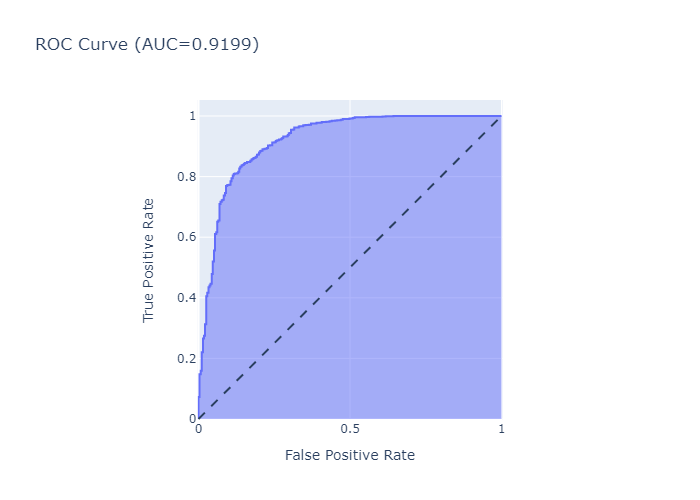

In [41]:
fpr, tpr, thresholds = roc_curve(target_test, gb_model.predict_proba(features_test_transform)[:,1])

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show('png')


Целевая метрика ROC AUC равна 0.92, что больше минимально необходимого значения. Precision модели составляет 0.95, recall равен 0.9. По матрице ошибок видно, что полученная модель склонна ошибочно присваивать больше негативную метку, чем положительную.

Также изучим важность признаков с помощью `Catboost`.

,Feature Id,Importances
0,days_active,76.362866
1,total_charges,7.049753
2,monthly_charges,5.499715
3,type_Two year,1.823967
4,multiple_lines_Yes,1.452327
5,partner_Yes,1.203811
6,type_One year,1.021570
7,payment_method_Mailed check,0.702204
8,streaming_movies_Yes,0.643408
9,online_backup_Yes,0.617100


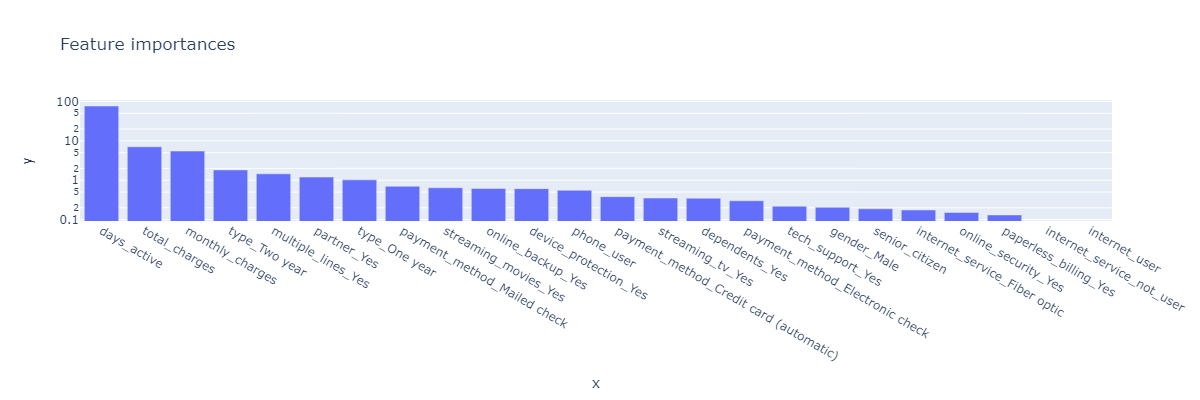

In [42]:
feat_imp = gb_best_model.get_feature_importance(prettified=True)

display(feat_imp)

#используем логарифмическую шкалу, иначе график будет неинформативен
fig = px.bar(x=feat_imp['Feature Id'], y=feat_imp['Importances'], title='Feature importances', log_y=True, width=1200, height=400)

fig.show('png')

Наибольшее влияние имеют численные признаки: `days_active`, `total_charges`, `monthly_charges`, с наибольшим преобладанием первой фичи. Остальные категориальные данные обладают минорным влиянием на итоговое предсказание модели.

## Итоги

Мы обучили и испытали модель, предсказывающую уход клиента в ближайшем будущем. В процессе работы было сделано:
* Были подготовлены и исследованы представленные датасеты.
* На основе данных были синтезированы дополнительные искусственные признаки.
* Исходная выборка была разбита на тренировочную и тестовую в соотношении 3:1.
* Категориальные признаки были преобразованы по методу OHE.
* Числовые признаки были стандартизированы.
* Было обучено 3 разных модели ML: логистическая регрессия, рандомный лес и градиентный бустинг. Модели обучались с помощью кросс-валидации.
* Наилучшие результаты показала модель градиентного бустинга.
* Модель была успешно протестирована на тестовой выборке.
* Наибольшее влияние оказывают фичи `days_active`, `total_charges`, `monthly_charges`. Остальные признаки изменяют вывод модели достаточно незначительно.
* Итоговая метрика ROC-AUC: 0.92, precision: 0.95, recall: 0.9.